# DG H-S Paper: FMS comparison

In [1]:
#modules
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import ndimage
from scipy import integrate

In [2]:
def print_ncinfo(dataset):
    for var in dataset.variables:
        var1 = dataset.variables[var]
        for name in var1.ncattrs():
            print var, '-->',name, '=', getattr(var1,name)
            
def append_year_days_onevar(fn, day_list, var_name, enable_print_ncinfo=False):
    ncdata =Dataset(fn%1,'r')
    if enable_print_ncinfo==True:
        print_ncinfo(ncdata)
    zon_waven = ncdata.variables['zon_waven'][:]
    legendre = ncdata.variables['legendre'][:]
    lat = ncdata.variables['lat'][:]
    lon = ncdata.variables['lon'][:]
    sig=ncdata.variables['sigma'][:]
    var_=ncdata.variables[var_name][:]
    ncdata.close()
    var = np.zeros((np.shape(var_)))[np.newaxis, ...]
    for d_i, d in enumerate(np.arange(1,len(day_list))):
        ncdata = Dataset(fn%d,'r')
        var=np.append(var, (ncdata.variables[var_name][:])[np.newaxis, ...], axis = 0)
        ncdata.close()
    
    return zon_waven, legendre, lat, lon, sig, var


def append_year_days_zonal_mean(fn, day_list, eddy_stats = True, enable_print_ncinfo=False):
    ncdata =Dataset(fn%1,'r')
    if enable_print_ncinfo==True:
        print_ncinfo(ncdata)
    lat = ncdata.variables['lat'][:]
    lon = ncdata.variables['lon'][:]
    sig=ncdata.variables['sigma'][:]
    ncdata.close()
    v = np.zeros((len(day_list), len(sig), len(lat)))
    u = np.zeros((len(day_list), len(sig), len(lat)))
    T = np.zeros((len(day_list), len(sig), len(lat)))
    uv = np.zeros((len(day_list), len(sig), len(lat)))
    vT = np.zeros((len(day_list), len(sig), len(lat)))
    TT = np.zeros((len(day_list), len(sig), len(lat)))
    eke = np.zeros((len(day_list), len(sig), len(lat)))
    for d_i, d in enumerate(np.arange(1,len(day_list))):
        ncdata = Dataset(fn%d,'r')
        v[d_i,:,:]=np.mean(ncdata.variables['v'][:],axis=-1)
        u[d_i,:,:]=np.mean(ncdata.variables['u'][:],axis=-1)
        T[d_i,:,:]=np.mean(ncdata.variables['temp'][:],axis=-1)
        if eddy_stats ==True:
            vST = ncdata.variables['v'][:] - v[d_i,:,:,None]
            uST = ncdata.variables['u'][:] - u[d_i,:,:,None]           
            TST = ncdata.variables['temp'][:] - T[d_i,:,:,None]
            uv[d_i,:,:]=np.mean(uST*vST,axis=-1)
            vT[d_i,:,:]=np.mean(vST*TST,axis=-1)
            TT[d_i,:,:]=np.mean(TST*TST,axis=-1)
            eke[d_i,:,:]=np.mean(uST**2+vST**2,axis=-1)
        ncdata.close()
    
    return lat, lon, sig, v, u, T, uv, vT, TT, eke

# Zonal means

In [18]:
# dirs / fnames
day_list = np.arange(500,900)

exp_name = "hs_control_num_fourier_63_num_num_spherical_64_lon_max_192_lat_max_96_num_levels_30_include_surface_flux_.false._turb_.false."
data_dir = "/central/scratch/elencz/caltech_fms_idealized/hs_control/%s/output/ppp_output/"%exp_name
fname = "day1000h00.segment%s.nc"

lat, lon, sig, v, u, T, uv, vT, TT, eke = append_year_days_zonal_mean(data_dir+fname, day_list)

In [23]:
# plotting helpers
def zonal_plot(lat, lev, var, title = '', subplot_no=(1,1,1), vrange = 20):
    a,b,c = subplot_no
    plt.subplot(a,b,c)
    f1 = plt.contourf(lat, lev, var, vrange)
    plt.colorbar(f1)
    plt.gca().invert_yaxis()
    plt.title(title)

# diagnostic helpers
def psi(V_xBAR,level_list_array,lat):
    _a, _g = (6371000., 9.81) # Earth_radius, grav_constant
    latrad = lat*np.pi/180.
    psi = _a/_g * 2. * np.pi * np.cos(latrad)[None,None,:] * integrate.cumtrapz(V_xBAR,level_list_array,axis = 1)
    return psi



hs_control_num_fourier_63_num_num_spherical_64_lon_max_192_lat_max_96_num_levels_30_include_surface_flux_.false._turb_.false.


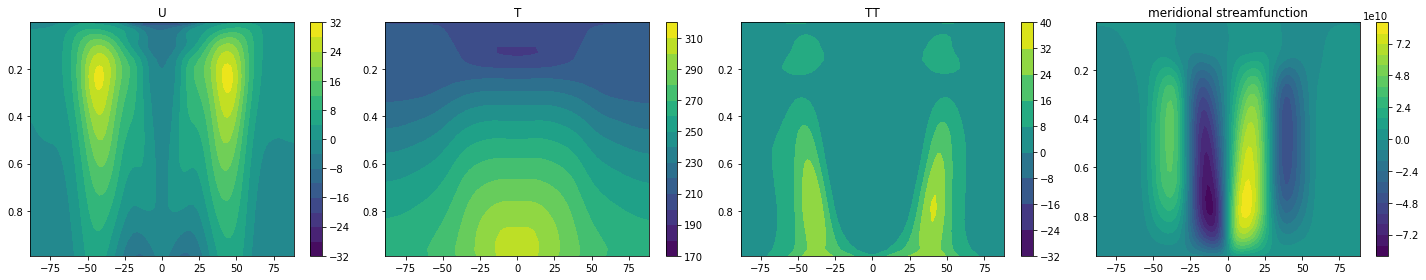

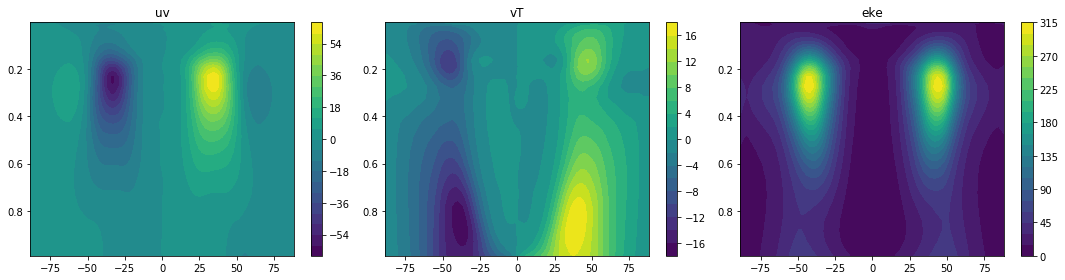

In [27]:
# Viz zonal means

# U, T, meridional streamfunctions
plt.figure(figsize=(20,4))
zonal_plot(lat, sig, np.mean(u,axis=0), title = 'U', subplot_no = (1,4,1), vrange = np.arange(-32,33,4))
zonal_plot(lat, sig, np.mean(T,axis=0), title = 'T', subplot_no = (1,4,2), vrange = np.arange(170,330,10))
zonal_plot(lat, sig, np.mean(TT,axis=0), title = 'TT', subplot_no = (1,4,3), vrange = np.arange(-32,41,8))
pressure = sig * 100000.0 # units: Pa
zonal_plot(lat, sig[:-1], np.mean(psi(v, pressure ,lat),axis=0), title = 'meridional streamfunction', subplot_no = (1,4,4))

# vT, uv, u^2+v^2, TT
plt.figure(figsize=(20,4))
zonal_plot(lat, sig, np.mean(uv,axis=0), title = 'uv', subplot_no = (1,4,1))
zonal_plot(lat, sig, np.mean(vT,axis=0), title = 'vT', subplot_no = (1,4,2))
zonal_plot(lat, sig, np.mean(0.5*eke,axis=0), title = 'eke', subplot_no = (1,4,3))


print(exp_name)

# Spectral

In [7]:
# spectral info
zonal_wn, legendre, lat, lon, sig, var = append_year_days_onevar(data_dir+fname, day_list, 'pot_temp_psd') #flipped (zon_wavenDimID, legendreDimID, sigmaDimID)




(400, 30, 64, 64)


/central/home/elencz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


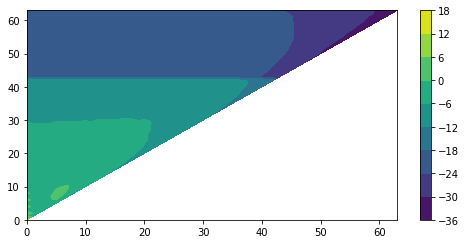

In [29]:
print(np.shape(var))

sig_i700 = [i for i,x in enumerate(sig) if ((x > 0.7) & (x < 0.8))][0]
f1 = plt.contourf(legendre, zonal_wn, np.log(np.mean(var,axis=0)[sig_i700,:,:]))#, np.arange(-10e-2, 10e-2, 10e-3))
plt.colorbar(f1)



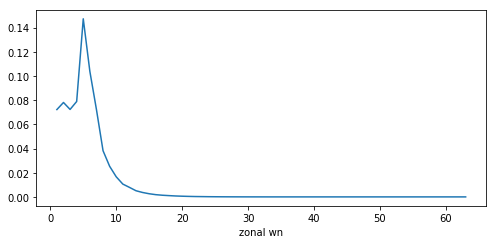

In [30]:
plt.plot(zonal_wn[1:],np.mean(var[1:,sig_i700,:,1:],axis=(0,-2)))
plt.xlabel("power spectral density")
plt.xlabel("zonal wn")
plt.show()

# Horizontal animation

In [15]:
# Viz animation

zonal_wn, legendre, lat, lon, sig, u_full = append_year_days_onevar(data_dir+fname, day_list, 'u')

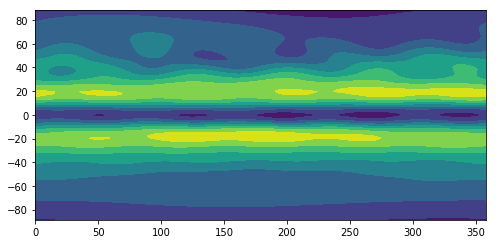

In [16]:
plt.contourf(lon, lat, (u_full[1,sig_i500,:,:]))
from IPython.display import HTML

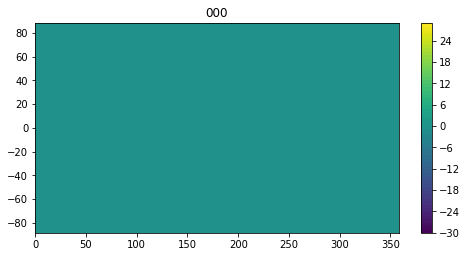

In [17]:
#%matplotlib notebook
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

sig_i700 = [i for i,x in enumerate(sig) if ((x > 0.7) & (x < 0.8))][0]


plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
f1 = ax.contourf(lon, lat, u[1,sig_i700,:,:],np.arange(-30,30,1))
plt.colorbar(f1)

def animate(frame_num):
    ax.clear()
    ax.contourf(lon, lat, u[frame_num,sig_i700,:,:],np.arange(-30,30,1))
    ax.set_title('%03d'%frame_num) 
    return ax
    
anim = animation.FuncAnimation(fig, animate, 300, interval=50, blit=False)
plt.show()